# Lorenz curves

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from itrx import Itr

from utils import CATEGORIES, Month, load_crime_data, lorenz_curve, monthgen

In [10]:
# get the crime data
FORCE = "West Yorkshire"
LATEST_DATE = Month(2025, 5)
crime_data = load_crime_data(FORCE, Itr(monthgen(LATEST_DATE, backwards=True)).take(36).rev())
crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,
5595af42450784687d49fbac869eea6fcf80cc0b9216cdf52b5ba29493e70d5b,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Park/Open Space,E01007418,Barnsley 016A,Public order,POINT (428510.985 412445.001)
0a55896e95eae6efc9f1d96e2338b7ae58c8c2e903ce55cd180ad85772173791,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Cocking Lane,E01010646,Bradford 001A,Criminal damage and arson,POINT (407795.98 448637.999)
6ef8495fb8063b21759a66268016972e7ac403e1a4d3d0ee394eaaeb99edbbf4,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Beacon Street,E01010646,Bradford 001A,Other theft,POINT (408373.007 449758.96)
ed7bc5cf1e0d6d98e657d84d9145e28e1741257afd40893d0397350a7d97728e,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Beacon Street,E01010646,Bradford 001A,Other theft,POINT (408373.007 449758.96)
d39b91fd1beb6d981ca79be112354879477f97ee610684c95298d6d90c499e1b,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Cross End Fold,E01010646,Bradford 001A,Public order,POINT (408037.995 449751.034)
...,...,...,...,...,...,...,...,...
3936ab0e2fd239fb68cbb3749d2db27e73aeb1c1265abef4ee4e9bcf8f111805,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Mill Street,E01011872,Wakefield 045D,Violence and sexual offences,POINT (444424.007 410686.031)
2d4730ccf43dbdf19f614cd34084afe6ded3e7dad5a5e79b70c61b1acfc247b9,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Mill Lane Villas,E01011872,Wakefield 045D,Violence and sexual offences,POINT (444518.988 410582.003)
b987d5101a01108a62245d0aa788817221f5b3274e403305bc6e83e935061b94,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Holmsley Mount,E01011872,Wakefield 045D,Violence and sexual offences,POINT (444333.024 410802.003)


In [15]:
# compute spatio-temporo-categorical counts
all_lsoas = crime_data["LSOA code"].unique()
all_categories = crime_data["Crime type"].unique()
counts = crime_data.groupby(["Month", "LSOA code", "Crime type"])["Reported by"].count()
counts

Month    LSOA code  Crime type                  
2022-06  E01005410  Drugs                            1
         E01007418  Public order                     1
         E01010568  Public order                     2
                    Vehicle crime                    1
                    Violence and sexual offences     2
                                                    ..
2025-05  E01035054  Robbery                          2
                    Shoplifting                      6
                    Theft from the person            1
                    Vehicle crime                    5
                    Violence and sexual offences    11
Name: Reported by, Length: 288218, dtype: int64

## See how stable rates are for 3 categories

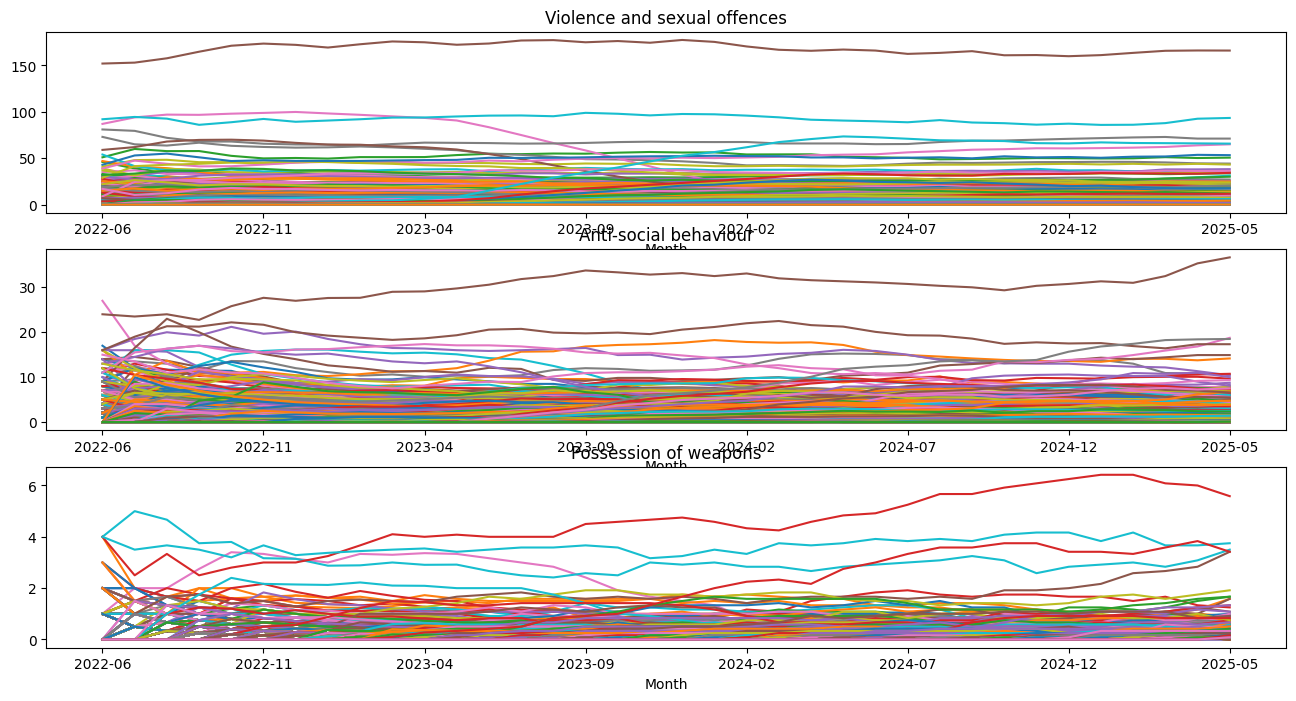

In [6]:
fig, axs = plt.subplots(3, figsize=(18, 9))
for i, category in enumerate(CATEGORIES):
    cat_counts = (
        counts.loc[(slice(None), slice(None), category)]
        .unstack(level="LSOA code", fill_value=0)
        .rolling(12, min_periods=1)
        .mean()
    )
    cat_counts.plot(legend=False, figsize=(16, 8), title=category, ax=axs[i])

## Compute Lorenz curves for the 3 year mean in each locations for each category

Text(0.5, 1.0, 'Lorenz curves')

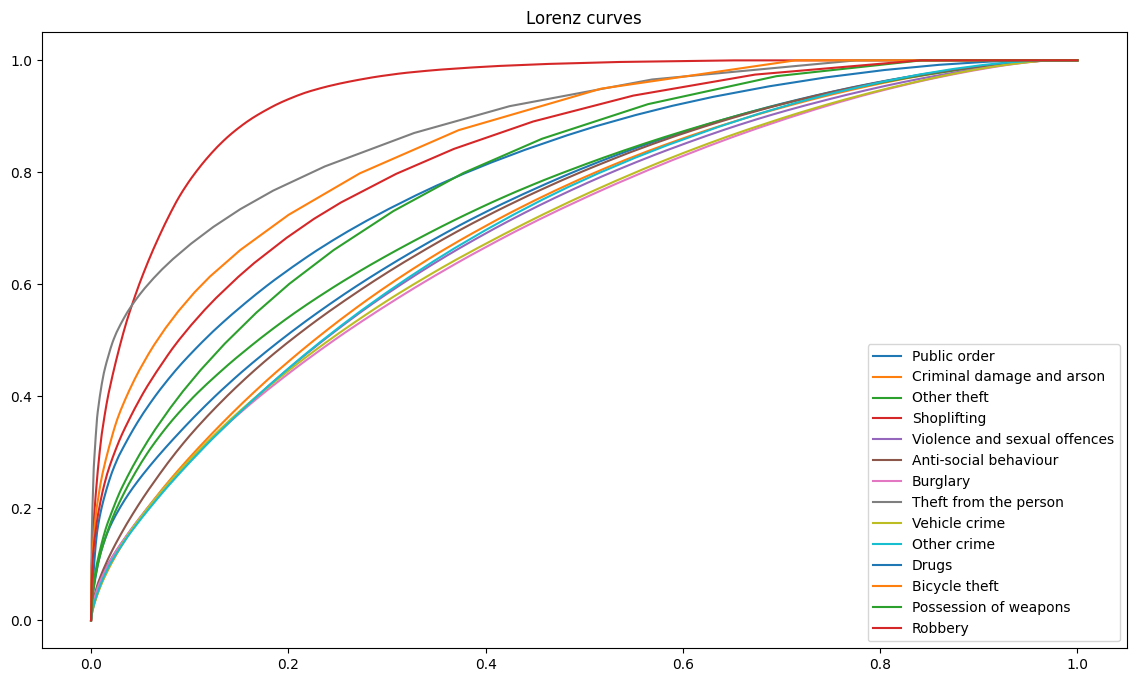

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))
for category in all_categories:
    # annualise (somewhat pointless as is gets normalised)
    cat_means = counts.loc[(slice(None), slice(None), category)].unstack(level="LSOA code", fill_value=0).mean() * 12
    # ensure we include LSOAs where no crimes occurred in this category
    cat_means = cat_means.reindex(all_lsoas, fill_value=0).sort_values()
    # cat_counts.plot(legend=False, figsize=(16, 8), title=category, ax=axs[i])
    lc = lorenz_curve(cat_means)
    lc.plot(label=category, ax=ax)
ax.legend()
ax.set_title("Lorenz curves")